In [17]:
# Imports
from pathlib import Path
import pandas as pd
import numpy as np
import tensorflow as tf
#import tensorflow_hub as hub
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector

#from sklearn.metrics import plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
#from sklearn.metrics import plot_confusion_matrix
#from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import unicodedata
import random
from sklearn.model_selection import GridSearchCV

from transformers import BertTokenizer, BertModel
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [37]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [2]:
df = pd.read_csv("../data/brand_product_emotion.csv", encoding= 'unicode_escape')

In [3]:
sw = stopwords.words('english')

## Cleaning DB

In [4]:
new_col_names = {'tweet_text': 'tweet', 
                 'emotion_in_tweet_is_directed_at':'brand_product', 
                 'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}
df = df.rename(columns=new_col_names)

In [5]:
df['emotion'] = df['emotion'].replace("Positive emotion","positive")
df['emotion'] = df['emotion'].replace("Negative emotion","negative")
df['emotion'] = df['emotion'].replace("No emotion toward brand or product","neutral")
df['emotion'] = df['emotion'].replace("I can't tell","unknown")

In [6]:
emotion_map = {'neutral': 0, 'positive': 1, 'negative': 2, 'unknown':3}
df['target'] = df['emotion'].map(emotion_map)

In [7]:
df.drop('emotion', axis = 1, inplace = True)
#df.drop('device', axis = 1, inplace = True)

In [8]:
df['tweet'] = df['tweet'].fillna('unknown')

In [9]:
df_touse = df[df['target']!= 3]

In [12]:
df_touse

,tweet,brand_product,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,2
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,2
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,1
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,0
9090,"Google's Zeiger, a physician never reported po...",NaN,0
9091,Some Verizon iPhone customers complained their...,NaN,0


### Model with stricter regularization and ensambling

In [46]:
#functions for preprocessing texts
def preprocess_tweet(tweet):

    # Define regex pattern for tokenization
    # This should remove @mentions, @users, and #hashtags. 
    regex_pattern = r"(?:\b[a-zA-Z]+(?:'[a-zA-Z]+)?\b|\@\w+|\#\w+|[^\w\s]+)"
    regex_token = RegexpTokenizer(regex_pattern)
    
    # Tokenize the tweet
    tokens = regex_token.tokenize(tweet)
    
    # Convert tokens to lowercase
    tokens = [token.lower() for token in tokens]
    
    # Remove stop words
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Perform part-of-speech tagging
    #tagged_tokens = pos_tag(tokens)
    
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    #lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(pos_tag)) for token, pos_tag in tagged_tokens]
    
    # Join tokens back into a string
    preprocessed_tweet = ' '.join(lemmatized_tokens)
    
    return preprocessed_tweet

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'  # Adjective
    elif treebank_tag.startswith('V'):
        return 'v'  # Verb
    elif treebank_tag.startswith('N'):
        return 'n'  # Noun
    elif treebank_tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'n'  # Default to Noun

In [26]:
X = df_touse['tweet'].apply(preprocess_tweet)
y = df_touse['target']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [27]:
# Create a pipeline for each classifier
mnb_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("mnb", MultinomialNB())
])

svm_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("svm", SVC(kernel='linear'))
])

cnn_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("cnn", MLPClassifier(hidden_layer_sizes=(100,), max_iter=500))
])

In [28]:
# Create the ensemble classifier using voting
ensemble_classifier = VotingClassifier(
    estimators=[("mnb", mnb_pipeline), ("svm", svm_pipeline), ("cnn", cnn_pipeline)],
    voting="hard"
)

In [29]:
# Train the ensemble classifier
ensemble_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('mnb',
                              Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('mnb', MultinomialNB())])),
                             ('svm',
                              Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('svm', SVC(kernel='linear'))])),
                             ('cnn',
                              Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('cnn',
                                               MLPClassifier(max_iter=500))]))])

In [30]:
y_pred = ensemble_classifier.predict(X_test)

F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (99) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (99) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (99) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (99) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\

CV Results for `ensemble` model:
            0.68891 ± 0.01081 accuracy
        


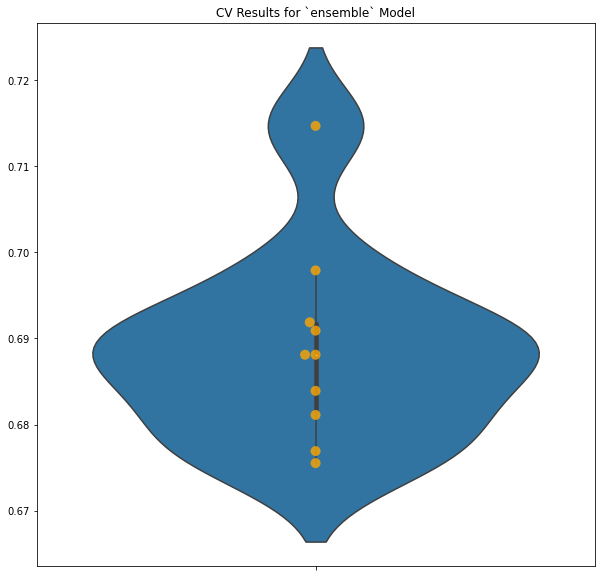

In [38]:
train_cv_model = ModelWithCV(
    ensemble_classifier,
model_name = 'ensemble',
X = X_train,
y = y_train)
fig, ax = plt.subplots(figsize = (10,10))
train_cv_model.plot_cv(ax=ax)
train_cv_model.print_cv_summary()

              precision    recall  f1-score   support

           0       0.70      0.88      0.78      1095
           1       0.64      0.44      0.53       571
           2       0.55      0.09      0.15       122

    accuracy                           0.69      1788
   macro avg       0.63      0.47      0.49      1788
weighted avg       0.67      0.69      0.66      1788



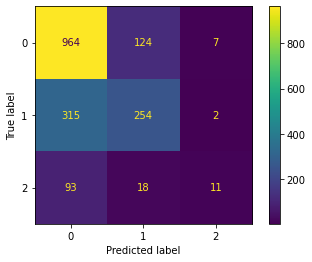

In [32]:
#eval model
report = classification_report(y_test, y_pred)
print(report)
#make a conf matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

### BELOW HAS BEEN COMMENTED OUT FOR THE SAKE OF YOUR PC, BUT THIS IS WHAT I USED FOR THE ENSAMBLING
- uncomment and run at your own risk

F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1: Train Accuracy = 0.744, Validation Accuracy = 0.666


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2: Train Accuracy = 0.743, Validation Accuracy = 0.666


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3: Train Accuracy = 0.779, Validation Accuracy = 0.677


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4: Train Accuracy = 0.800, Validation Accuracy = 0.678


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5: Train Accuracy = 0.820, Validation Accuracy = 0.688


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6: Train Accuracy = 0.827, Validation Accuracy = 0.688


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (7) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7: Train Accuracy = 0.834, Validation Accuracy = 0.687


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8: Train Accuracy = 0.836, Validation Accuracy = 0.685


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (9) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9: Train Accuracy = 0.838, Validation Accuracy = 0.687


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10: Train Accuracy = 0.839, Validation Accuracy = 0.687


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 11: Train Accuracy = 0.840, Validation Accuracy = 0.686


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 12: Train Accuracy = 0.841, Validation Accuracy = 0.687


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (13) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 13: Train Accuracy = 0.841, Validation Accuracy = 0.686


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (14) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 14: Train Accuracy = 0.842, Validation Accuracy = 0.687


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 15: Train Accuracy = 0.842, Validation Accuracy = 0.686


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 16: Train Accuracy = 0.843, Validation Accuracy = 0.688


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (17) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 17: Train Accuracy = 0.842, Validation Accuracy = 0.683


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (18) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 18: Train Accuracy = 0.842, Validation Accuracy = 0.683


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 19: Train Accuracy = 0.843, Validation Accuracy = 0.686


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 20: Train Accuracy = 0.844, Validation Accuracy = 0.683


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 21: Train Accuracy = 0.843, Validation Accuracy = 0.684


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 22: Train Accuracy = 0.844, Validation Accuracy = 0.685


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 23: Train Accuracy = 0.843, Validation Accuracy = 0.683


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 24: Train Accuracy = 0.844, Validation Accuracy = 0.681


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 25: Train Accuracy = 0.844, Validation Accuracy = 0.681


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (26) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 26: Train Accuracy = 0.845, Validation Accuracy = 0.683


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (27) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 27: Train Accuracy = 0.845, Validation Accuracy = 0.681


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 28: Train Accuracy = 0.846, Validation Accuracy = 0.681


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (29) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 29: Train Accuracy = 0.846, Validation Accuracy = 0.681


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 30: Train Accuracy = 0.846, Validation Accuracy = 0.682


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (31) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 31: Train Accuracy = 0.845, Validation Accuracy = 0.682


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (32) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 32: Train Accuracy = 0.847, Validation Accuracy = 0.681


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (33) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 33: Train Accuracy = 0.844, Validation Accuracy = 0.683


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (34) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 34: Train Accuracy = 0.846, Validation Accuracy = 0.681


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (35) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 35: Train Accuracy = 0.846, Validation Accuracy = 0.680


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (36) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 36: Train Accuracy = 0.846, Validation Accuracy = 0.681


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (37) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 37: Train Accuracy = 0.846, Validation Accuracy = 0.681


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 38: Train Accuracy = 0.848, Validation Accuracy = 0.678


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (39) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 39: Train Accuracy = 0.847, Validation Accuracy = 0.680


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 40: Train Accuracy = 0.848, Validation Accuracy = 0.678


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (41) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 41: Train Accuracy = 0.848, Validation Accuracy = 0.678


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (42) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 42: Train Accuracy = 0.848, Validation Accuracy = 0.680


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (43) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 43: Train Accuracy = 0.848, Validation Accuracy = 0.678


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (44) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 44: Train Accuracy = 0.848, Validation Accuracy = 0.679


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 45: Train Accuracy = 0.848, Validation Accuracy = 0.679


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (46) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 46: Train Accuracy = 0.847, Validation Accuracy = 0.679


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (47) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 47: Train Accuracy = 0.848, Validation Accuracy = 0.680


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 48: Train Accuracy = 0.848, Validation Accuracy = 0.680


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 49: Train Accuracy = 0.849, Validation Accuracy = 0.680


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 50: Train Accuracy = 0.849, Validation Accuracy = 0.678


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (51) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 51: Train Accuracy = 0.849, Validation Accuracy = 0.680


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (52) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 52: Train Accuracy = 0.849, Validation Accuracy = 0.681


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (53) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 53: Train Accuracy = 0.849, Validation Accuracy = 0.680


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (54) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 54: Train Accuracy = 0.850, Validation Accuracy = 0.679


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (55) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 55: Train Accuracy = 0.850, Validation Accuracy = 0.680


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (56) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 56: Train Accuracy = 0.848, Validation Accuracy = 0.681


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (57) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 57: Train Accuracy = 0.849, Validation Accuracy = 0.679


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (58) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 58: Train Accuracy = 0.850, Validation Accuracy = 0.678


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (59) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 59: Train Accuracy = 0.849, Validation Accuracy = 0.680


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 60: Train Accuracy = 0.849, Validation Accuracy = 0.679


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (61) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 61: Train Accuracy = 0.851, Validation Accuracy = 0.680


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (62) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 62: Train Accuracy = 0.848, Validation Accuracy = 0.681


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (63) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 63: Train Accuracy = 0.849, Validation Accuracy = 0.679


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (64) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 64: Train Accuracy = 0.850, Validation Accuracy = 0.678


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (65) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 65: Train Accuracy = 0.849, Validation Accuracy = 0.678


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (66) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 66: Train Accuracy = 0.850, Validation Accuracy = 0.681


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (67) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 67: Train Accuracy = 0.849, Validation Accuracy = 0.680


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (68) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 68: Train Accuracy = 0.849, Validation Accuracy = 0.681


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (69) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 69: Train Accuracy = 0.849, Validation Accuracy = 0.680


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 70: Train Accuracy = 0.850, Validation Accuracy = 0.681


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (71) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 71: Train Accuracy = 0.851, Validation Accuracy = 0.680


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (72) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 72: Train Accuracy = 0.851, Validation Accuracy = 0.683


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (73) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 73: Train Accuracy = 0.849, Validation Accuracy = 0.680


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (74) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 74: Train Accuracy = 0.850, Validation Accuracy = 0.682


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 75: Train Accuracy = 0.849, Validation Accuracy = 0.682


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (76) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 76: Train Accuracy = 0.851, Validation Accuracy = 0.679


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (77) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 77: Train Accuracy = 0.850, Validation Accuracy = 0.681


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (78) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 78: Train Accuracy = 0.850, Validation Accuracy = 0.681


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (79) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 79: Train Accuracy = 0.848, Validation Accuracy = 0.681


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 80: Train Accuracy = 0.851, Validation Accuracy = 0.680


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (81) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 81: Train Accuracy = 0.851, Validation Accuracy = 0.681


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (82) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 82: Train Accuracy = 0.849, Validation Accuracy = 0.681


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (83) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 83: Train Accuracy = 0.852, Validation Accuracy = 0.678


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (84) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 84: Train Accuracy = 0.851, Validation Accuracy = 0.679


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (85) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 85: Train Accuracy = 0.851, Validation Accuracy = 0.680


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (86) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 86: Train Accuracy = 0.849, Validation Accuracy = 0.680


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (87) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 87: Train Accuracy = 0.851, Validation Accuracy = 0.681


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (88) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 88: Train Accuracy = 0.851, Validation Accuracy = 0.678


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (89) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 89: Train Accuracy = 0.851, Validation Accuracy = 0.683


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (90) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 90: Train Accuracy = 0.850, Validation Accuracy = 0.678


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (91) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 91: Train Accuracy = 0.851, Validation Accuracy = 0.681


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (92) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 92: Train Accuracy = 0.851, Validation Accuracy = 0.681


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (93) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 93: Train Accuracy = 0.851, Validation Accuracy = 0.680


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (94) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 94: Train Accuracy = 0.851, Validation Accuracy = 0.682


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (95) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 95: Train Accuracy = 0.850, Validation Accuracy = 0.679


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (96) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 96: Train Accuracy = 0.850, Validation Accuracy = 0.680


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (97) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 97: Train Accuracy = 0.850, Validation Accuracy = 0.679


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (98) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 98: Train Accuracy = 0.851, Validation Accuracy = 0.678


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (99) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 99: Train Accuracy = 0.851, Validation Accuracy = 0.682


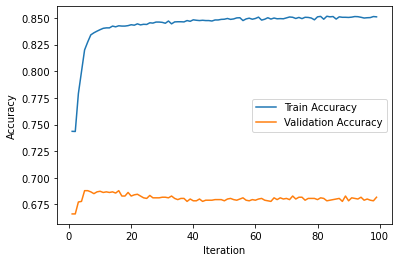

In [36]:
#visualizing
# Train the ensemble classifier


#train_acc_list = []
#val_acc_list = []
#iteration = []
#for i in range(1, 100):
#    ensemble_classifier.set_params(cnn__cnn__max_iter=i)  # Update max_iter for CNN
#    ensemble_classifier.fit(X_train, y_train)
#    
#    # Calculate accuracy on training set
#    train_acc = accuracy_score(y_train, ensemble_classifier.predict(X_train))
#    train_acc_list.append(train_acc)
    
    # Calculate accuracy on validation set
#    val_acc = accuracy_score(y_test, ensemble_classifier.predict(X_test))
#    val_acc_list.append(val_acc)
    
#    iteration.append(i)

#   print(f"Iteration {i}: Train Accuracy = {train_acc:.3f}, Validation Accuracy = {val_acc:.3f}")

# Plot learning curve
#plt.plot(iteration, train_acc_list, label="Train Accuracy")
#plt.plot(iteration, val_acc_list, label="Validation Accuracy")
#plt.xlabel("Iteration")
#plt.ylabel("Accuracy")
#plt.legend()
#plt.show()

This visualization took 2 hours lol. Not doing iterations again or have to make future ensembles quicker.

### Modeling with binary classifier (pos/neg) before continuing in multiclass

In [40]:
df_touse_2 = df_touse[df_touse['target'] != 0]

In [42]:
df_touse_2

,tweet,brand_product,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,2
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,2
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1
...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,1
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,1
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,2
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,1


In [51]:
X_bin = df_touse_2['tweet'].apply(preprocess_tweet)
y_bin = df_touse_2['target']

X_train, X_test, y_train, y_test = train_test_split(X_bin, 
                                                    y_bin, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [52]:
y_train.value_counts()

1    2383
2     455
Name: target, dtype: int64

In [53]:
#train on previous ensemble
ensemble_classifier = VotingClassifier(
    estimators=[("mnb", mnb_pipeline), ("svm", svm_pipeline), ("cnn", cnn_pipeline)],
    voting="hard"
)
ensemble_classifier.fit(X_train, y_train)

F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (99) reached and the optimization hasn't converged yet.
  warnings.warn(


VotingClassifier(estimators=[('mnb',
                              Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('mnb', MultinomialNB())])),
                             ('svm',
                              Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('svm', SVC(kernel='linear'))])),
                             ('cnn',
                              Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('cnn',
                                               MLPClassifier(max_iter=99))]))])

F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (99) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (99) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (99) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (99) reached and the optimization hasn't converged yet.
  warnings.warn(


CV Results for `ensemble_binary` model:
            0.87033 ± 0.01664 accuracy
        


F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (99) reached and the optimization hasn't converged yet.
  warnings.warn(


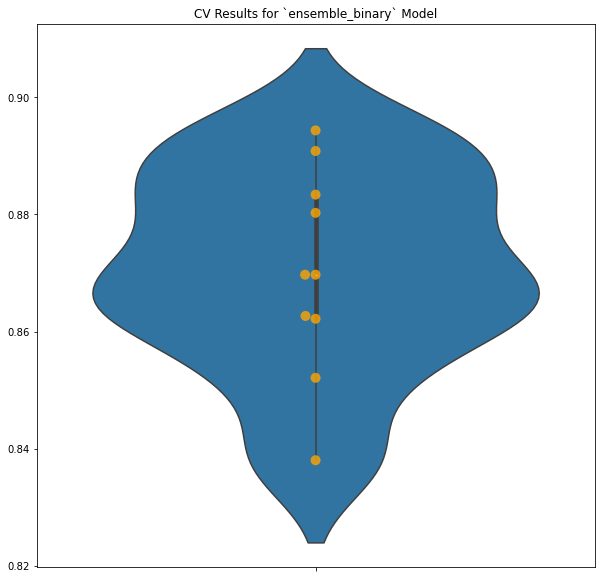

In [54]:
train_cv_model = ModelWithCV(
    ensemble_classifier,
model_name = 'ensemble_binary',
X = X_train,
y = y_train)

fig, ax = plt.subplots(figsize = (10,10))
train_cv_model.plot_cv(ax=ax)
train_cv_model.print_cv_summary()

              precision    recall  f1-score   support

           1       0.88      0.98      0.93       595
           2       0.77      0.30      0.43       115

    accuracy                           0.87       710
   macro avg       0.83      0.64      0.68       710
weighted avg       0.86      0.87      0.85       710



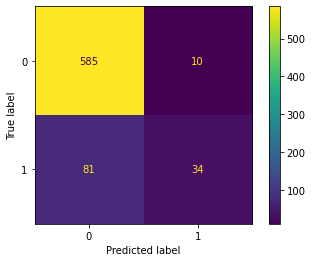

In [56]:
y_pred = ensemble_classifier.predict(X_test)
#eval model
report = classification_report(y_test, y_pred)
print(report)
#make a conf matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

Wow the binary didnt do as well as i'd like it to. 

### Modeling binary again but with countvect instead of tfidf

In [57]:
# Create a pipeline for each classifier
mnb_pipeline = Pipeline([
    ("cv", CountVectorizer()),
    ("mnb", MultinomialNB())
])

svm_pipeline = Pipeline([
    ("cv", CountVectorizer()),
    ("svm", SVC(kernel='linear'))
])

cnn_pipeline = Pipeline([
    ("cv", CountVectorizer()),
    ("cnn", MLPClassifier(hidden_layer_sizes=(100,), max_iter=500))
])

In [58]:
# Create the ensemble classifier using voting
ensemble_classifier = VotingClassifier(
    estimators=[("mnb", mnb_pipeline), ("svm", svm_pipeline), ("cnn", cnn_pipeline)],
    voting="hard"
)

In [59]:
ensemble_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('mnb',
                              Pipeline(steps=[('cv', CountVectorizer()),
                                              ('mnb', MultinomialNB())])),
                             ('svm',
                              Pipeline(steps=[('cv', CountVectorizer()),
                                              ('svm', SVC(kernel='linear'))])),
                             ('cnn',
                              Pipeline(steps=[('cv', CountVectorizer()),
                                              ('cnn',
                                               MLPClassifier(max_iter=500))]))])

CV Results for `ensemble_binary_2` model:
            0.87526 ± 0.02180 accuracy
        


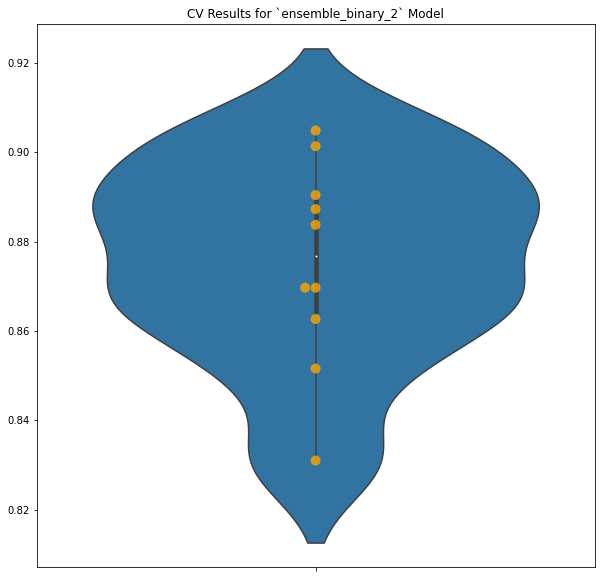

In [60]:
train_cv_model = ModelWithCV(
    ensemble_classifier,
model_name = 'ensemble_binary_2',
X = X_train,
y = y_train)

fig, ax = plt.subplots(figsize = (10,10))
train_cv_model.plot_cv(ax=ax)
train_cv_model.print_cv_summary()

              precision    recall  f1-score   support

           1       0.90      0.94      0.92       595
           2       0.61      0.47      0.53       115

    accuracy                           0.87       710
   macro avg       0.76      0.71      0.73       710
weighted avg       0.86      0.87      0.86       710



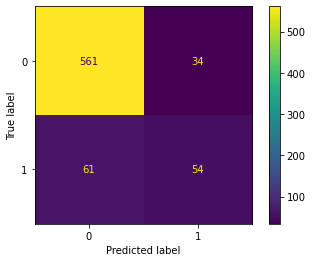

In [61]:
y_pred = ensemble_classifier.predict(X_test)
#eval model
report = classification_report(y_test, y_pred)
print(report)
#make a conf matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

- I think countvectorizer did slightly better, but i also just realized this wasnt preprocessing the text how I wanted it to.

- At this point i went to notebook "EDA_2" to figure out the proper word preprocessing

- Will be using preprocessing_text_4 from that notebook and try modeling again

### Modeling with properly processed texts

In [73]:
def preprocess_tweet_4(tweet):
    # Remove URLs, mentions, and hashtags
    text = ' '.join(word for word in tweet.split() if not (word.startswith('http') or word.startswith('@') or word.startswith('#') or word.startswith('{')))
    # Remove punctuation and convert to lowercase
    text = ''.join(char for char in text if char.isalnum() or char.isspace())
    text = text.lower()
    # Tokenize text and remove stop words
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in sw]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Remove 'rt' from the tokens
    tokens = [word for word in tokens if word != 'rt']
    
    # Remove 'ipad' from the tokens
    tokens = [word for word in tokens if word != 'ipad']
    
    # Remove 'google' from the tokens
    tokens = [word for word in tokens if word != 'google']
    
    # Remove 'iphone' from the tokens
    tokens = [word for word in tokens if word != 'iphone']

    # Remove 'apple' from the tokens
    tokens = [word for word in tokens if word != 'apple']
    
    #join back
    preprocessed_tweet = ' '.join(tokens)
    
    return preprocessed_tweet

In [74]:
X_bin = df_touse_2['tweet'].apply(preprocess_tweet_4)
y_bin = df_touse_2['target']

X_train, X_test, y_train, y_test = train_test_split(X_bin, 
                                                    y_bin, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [75]:
# Create the ensemble classifier using voting
# currently using CountVect instead of tfidf
ensemble_classifier = VotingClassifier(
    estimators=[("mnb", mnb_pipeline), ("svm", svm_pipeline), ("cnn", cnn_pipeline)],
    voting="hard"
)

In [76]:
ensemble_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('mnb',
                              Pipeline(steps=[('cv', CountVectorizer()),
                                              ('mnb', MultinomialNB())])),
                             ('svm',
                              Pipeline(steps=[('cv', CountVectorizer()),
                                              ('svm', SVC(kernel='linear'))])),
                             ('cnn',
                              Pipeline(steps=[('cv', CountVectorizer()),
                                              ('cnn',
                                               MLPClassifier(max_iter=500))]))])

CV Results for `ensemble_binary_2` model:
            0.87034 ± 0.01957 accuracy
        


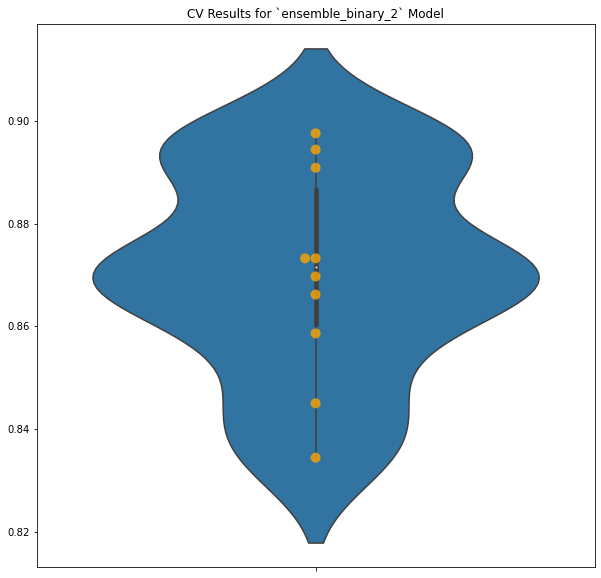

In [77]:
train_cv_model = ModelWithCV(
    ensemble_classifier,
model_name = 'ensemble_binary_2',
X = X_train,
y = y_train)

fig, ax = plt.subplots(figsize = (10,10))
train_cv_model.plot_cv(ax=ax)
train_cv_model.print_cv_summary()

              precision    recall  f1-score   support

           1       0.90      0.95      0.93       595
           2       0.66      0.47      0.55       115

    accuracy                           0.87       710
   macro avg       0.78      0.71      0.74       710
weighted avg       0.86      0.87      0.87       710



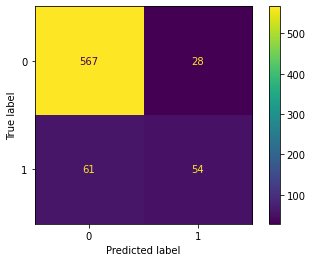

In [78]:
y_pred = ensemble_classifier.predict(X_test)
#eval model
report = classification_report(y_test, y_pred)
print(report)
#make a conf matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

Trying again with tfidf instead

In [79]:
# Create a pipeline for each classifier
mnb_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("mnb", MultinomialNB())
])

svm_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("svm", SVC(kernel='linear'))
])

cnn_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("cnn", MLPClassifier(hidden_layer_sizes=(100,), max_iter=500))
])

In [80]:
# Create the ensemble classifier using voting
# currently using tfidf instead of cv
ensemble_classifier = VotingClassifier(
    estimators=[("mnb", mnb_pipeline), ("svm", svm_pipeline), ("cnn", cnn_pipeline)],
    voting="hard"
)

In [81]:
ensemble_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('mnb',
                              Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('mnb', MultinomialNB())])),
                             ('svm',
                              Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('svm', SVC(kernel='linear'))])),
                             ('cnn',
                              Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('cnn',
                                               MLPClassifier(max_iter=500))]))])

CV Results for `ensemble_binary_2` model:
            0.87421 ± 0.00733 accuracy
        


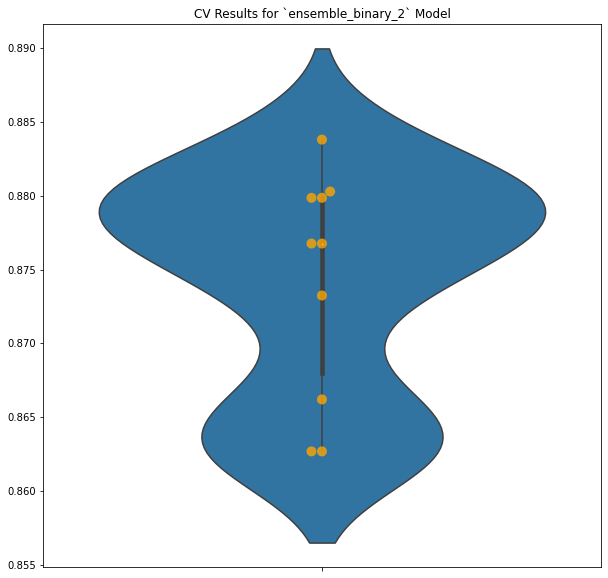

In [82]:
train_cv_model = ModelWithCV(
    ensemble_classifier,
model_name = 'ensemble_binary_2',
X = X_train,
y = y_train)

fig, ax = plt.subplots(figsize = (10,10))
train_cv_model.plot_cv(ax=ax)
train_cv_model.print_cv_summary()

              precision    recall  f1-score   support

           1       0.87      0.98      0.92       595
           2       0.71      0.22      0.33       115

    accuracy                           0.86       710
   macro avg       0.79      0.60      0.63       710
weighted avg       0.84      0.86      0.83       710



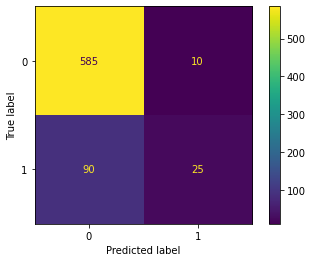

In [83]:
y_pred = ensemble_classifier.predict(X_test)
#eval model
report = classification_report(y_test, y_pred)
print(report)
#make a conf matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

well tfidf did worse again.
- will try more models without the ensembling. Scotty got better scores just running by itself. I will create each individ file for each model